In [1]:
# Base libraries
import numpy as np
import pandas as pd
from typing import Tuple
from scipy.stats import norm

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
class BS:
    def __init__(self, spot, strike, rate, dte, volatility):
        self.S = spot
        self.K = strike
        self.r = rate
        self.t = dte
        self.sigma = volatility
        
        # Calculate common terms used across methods
        self.time_sqrt = np.sqrt(self.t)
        self.discount_factor = np.exp(-self.r * self.t)
       
        # Calculate d1 and d2 parameters
        self.d1 = self._calculate_d1()
        self.d2 = self.d1 - self.sigma * self.time_sqrt
        
        # Calculate all option Greeks and prices
        self.call_price, self.put_price = self._price()
        self.call_delta, self.put_delta = self._delta()
        self.gamma = self._gamma()
        self.vega = self._vega()
        self.call_theta, self.put_theta = self._theta()
        self.call_rho, self.put_rho = self._rho()
       
    def _calculate_d1(self) -> float:
        return (np.log(self.S / self.K) + (self.r + (self.sigma**2) / 2) * self.t) / (
            self.sigma * self.time_sqrt
        )
    
    def _price(self) -> Tuple[float, float]:
        d1_cdf = norm.cdf(self.d1)
        d2_cdf = norm.cdf(self.d2)

        call = self.S * d1_cdf - self.K * self.discount_factor * d2_cdf
        put = self.K * self.discount_factor * norm.cdf(-self.d2) - self.S * norm.cdf(
            -self.d1
        )
        return call, put
    
    def _delta(self) -> Tuple[float, float]:
        d1_cdf = norm.cdf(self.d1)
        return d1_cdf, -norm.cdf(-self.d1)
    
    def _gamma(self) -> float:
        return norm.pdf(self.d1) / (self.S * self.sigma * self.time_sqrt)
    
    def _vega(self) -> float:
        return self.S * norm.pdf(self.d1) * self.time_sqrt / 100
    
    def _theta(self) -> Tuple[float, float]:
        spot_term = -self.S * norm.pdf(self.d1) * self.sigma / (2 * self.time_sqrt)
        call_rate_term = -self.r * self.K * self.discount_factor * norm.cdf(self.d2)
        put_rate_term = self.r * self.K * self.discount_factor * norm.cdf(-self.d2)

        return (spot_term + call_rate_term) / 365, (spot_term + put_rate_term) / 365
    
    def _rho(self) -> Tuple[float, float]:
        call = self.K * self.t * self.discount_factor * norm.cdf(self.d2) / 100
        put = -self.K * self.t * self.discount_factor * norm.cdf(-self.d2) / 100
        return call, put

In [3]:
# Initialize option
option = BS(100,100,0.05,1,0.2)

header = ['Type', 'Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [
    [
        'Call',
        option.call_price,
        option.call_delta,
        option.gamma,
        option.call_theta,
        option.vega,
        option.call_rho
    ],
    [   
        'Put',
        option.put_price,
        option.put_delta,
        option.gamma,
        option.put_theta,
        option.vega,        
        option.put_rho       
    ],
]

print(tabulate(table,header))

Type      Option Price      Delta     Gamma        Theta     Vega        Rho
------  --------------  ---------  --------  -----------  -------  ---------
Call          10.4506    0.636831  0.018762  -0.0175727   0.37524   0.532325
Put            5.57353  -0.363169  0.018762  -0.00454214  0.37524  -0.418905


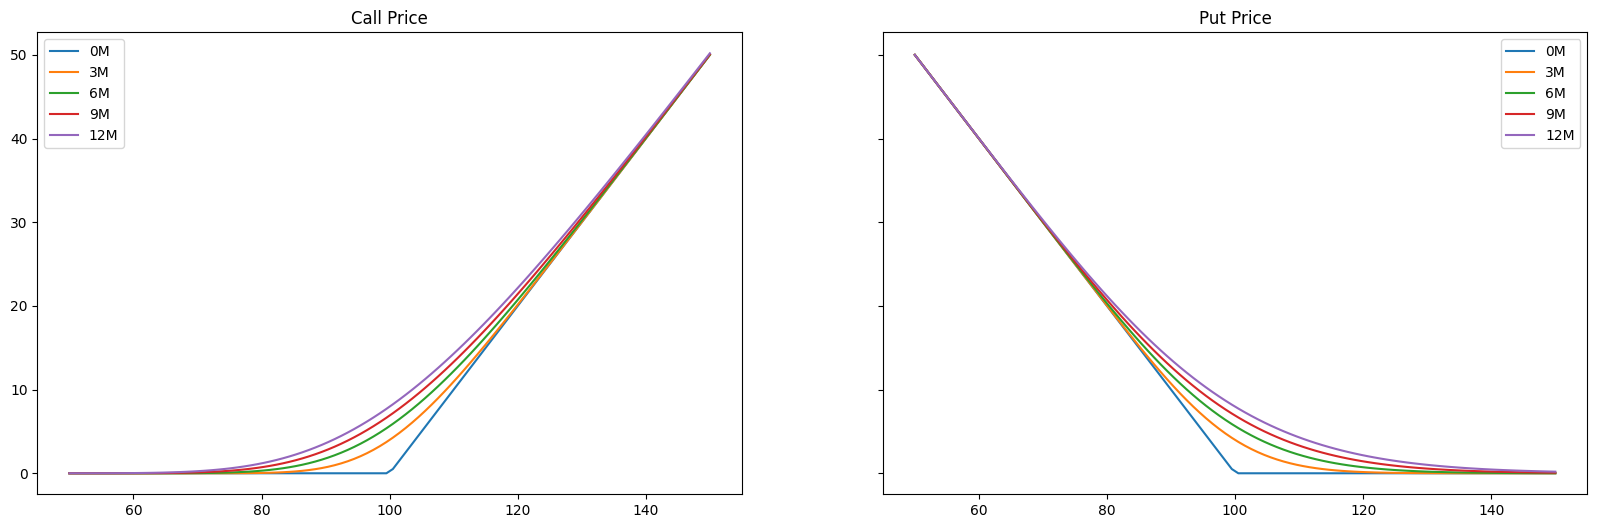

In [4]:
# Plot option values for range of spot prices over differece time
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define expirations and labels
d = {'0M': 1e-50, '3M': 0.25, '6M': 0.5, '9M': 0.75, '12M': 1.0}
x = np.linspace(50, 150, 100)

# Plot call and put prices
for label, tau in d.items():
    bs = BS(x, 100, 0.0, tau, 0.2)
    axes[0].plot(x, bs.call_price, label=label)
    axes[1].plot(x, bs.put_price, label=label)

# Set titles and legends
for ax, title in zip(axes, ["Call Price", "Put Price"]):
    ax.set_title(title)
    ax.legend()

plt.show()


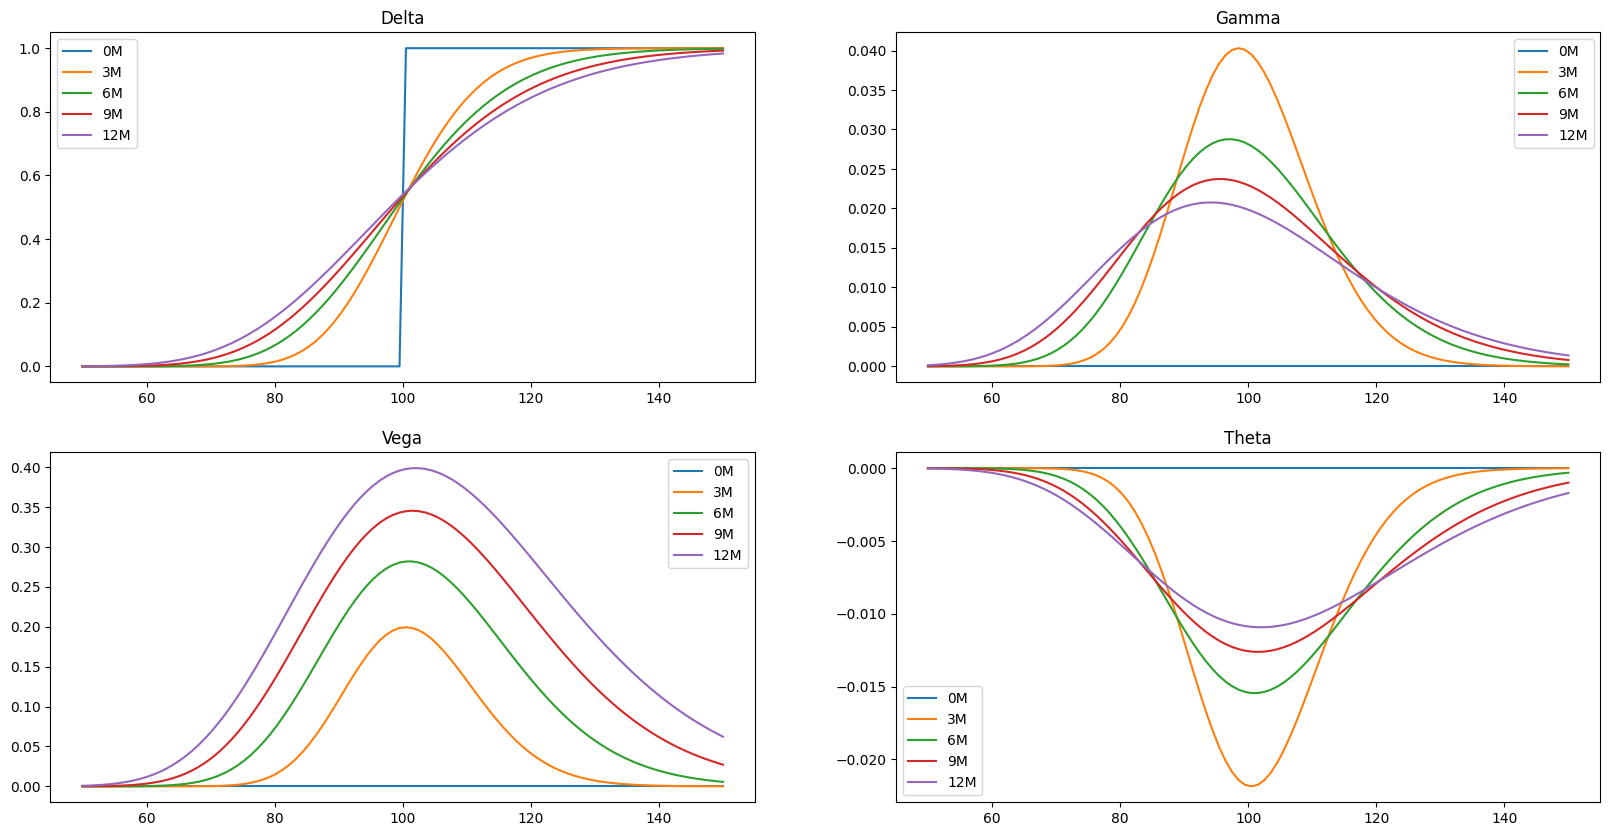

In [5]:
# Plot graph iteratively
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Define Greeks and their respective subplot positions
greeks = {
    (0, 0): ('call_delta', 'Delta'),
    (0, 1): ('gamma', 'Gamma'),
    (1, 0): ('vega', 'Vega'),
    (1, 1): ('call_theta', 'Theta')
}

# Plot all Greeks in one loop
for (i, j), (attr, title) in greeks.items():
    for label, tau in d.items():
        ax[i, j].plot(x, getattr(BS(x, 100, 0.0, tau, 0.2), attr), label=label)
    ax[i, j].set_title(title)
    ax[i, j].legend()

plt.show()


In [6]:
# update quantmod to version 0.0.6 for NSE options
from quantmod.derivatives import OptionData
from datetime import datetime, timedelta
from quantmod.models import OptionInputs, BlackScholesOptionPricing

In [7]:
# Get option chain for specify expiry
expiration = '27-Mar-2025'
valuation = datetime.today()
ttm = (pd.to_datetime(expiration+' 15:30:00') - pd.to_datetime(valuation)) / timedelta(days=365)

# Instantiate the Option Data
opt = OptionData("NIFTY", expiration)
df = opt.get_call_option_data
df.head(2)

,strikePrice,expiryDate,underlying,identifier,openInterest,changeinOpenInterest,pchangeinOpenInterest,totalTradedVolume,impliedVolatility,lastPrice,change,pChange,totalBuyQuantity,totalSellQuantity,bidQty,bidprice,askQty,askPrice,underlyingValue
0,18000,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE18000.00,5948.666667,-119.0,-1.961215,169,78.28,4902.4,333.65,7.302873,8850,4575,150,4886.15,75,4900.25,22834.3
1,19000,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE19000.00,916.333333,-26.0,-2.759109,115,53.93,3889.7,308.80,8.623530,7125,3975,75,3895.00,75,3905.10,22834.3


In [8]:
# querry strikes between 22000 and 22500
df = df.query('strikePrice>=22000 and strikePrice<=23000').reset_index(drop=True)
df.head()

,strikePrice,expiryDate,underlying,identifier,openInterest,changeinOpenInterest,pchangeinOpenInterest,totalTradedVolume,impliedVolatility,lastPrice,change,pChange,totalBuyQuantity,totalSellQuantity,bidQty,bidprice,askQty,askPrice,underlyingValue
0,22000,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE22000.00,20697.666667,-2849.333333,-12.100621,11751,19.15,917.85,299.55,48.447356,21750,13650,75,917.85,75,920.00,22834.3
1,22050,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE22050.00,608.000000,-55.000000,-8.295626,164,18.82,871.00,298.50,52.139738,9900,7125,450,860.15,225,876.25,22834.3
2,22100,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE22100.00,3227.000000,-415.000000,-11.394838,2293,18.39,823.80,296.00,56.081849,15300,8025,150,821.65,150,826.90,22834.3
3,22150,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE22150.00,737.000000,-49.000000,-6.234097,327,18.11,778.00,284.90,57.777327,13425,6900,1650,778.00,150,779.50,22834.3
4,22200,27-Mar-2025,NIFTY,OPTIDXNIFTY27-03-2025CE22200.00,10119.000000,-955.000000,-8.623804,3762,17.61,731.00,284.05,63.552970,16875,10125,675,728.70,150,731.90,22834.3


In [9]:
# Dataframe manipulation with selected fields
df1 = pd.DataFrame({'Strike': df['strikePrice'],
                    'Price': df['lastPrice'],
                    })

# Instantiate BS Pricing Engine from quantmod and Derive Implied Volatiliy
for i in range(len(df1)):
    nifty = BlackScholesOptionPricing(
        OptionInputs(
            spot = 22400,
            strike = df1['Strike'].iloc[i], 
            rate = 0.0,
            ttm = ttm,
            volatility = 0.20,
            callprice = df1['Price'].iloc[i]
            )
        )
        
    df1.loc[i, 'ImpVol'] = nifty.impvol
    
# Check output
df1.head(10)

,Strike,Price,ImpVol
0,22000,917.85,0.503033
1,22050,871.00,0.489545
2,22100,823.80,0.475556
3,22150,778.00,0.462319
4,22200,731.00,0.447920
5,22250,681.15,0.431157
6,22300,637.00,0.418144
7,22350,593.00,0.404840
8,22400,549.15,0.391205
9,22450,502.15,0.374840


In [10]:
# Derive greeks and assign to dataframe as columns
for i in range(len(df1)):
    # initializing the BS option object
    nifty = BS(
        spot = 22400, 
        strike = df1['Strike'].iloc[i], 
        rate = 0.0,
        dte = ttm, 
        volatility=df1['ImpVol'].iloc[i]
        )
    # assign greeks to dataframe 
    df1.loc[i, 'Delta'] = nifty.call_delta
    df1.loc[i, 'Gamma'] = nifty.gamma
    df1.loc[i, 'Vega'] = nifty.vega
    df1.loc[i, 'Theta'] = nifty.call_theta
    
# Verify output
df1.head(10)

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,22000,917.85,0.503033,0.605462,0.000217,13.546147,-37.817712
1,22050,871.00,0.489545,0.596081,0.000225,13.630447,-37.032736
2,22100,823.80,0.475556,0.586217,0.000233,13.710464,-36.185687
3,22150,778.00,0.462319,0.575674,0.000241,13.786274,-35.373004
4,22200,731.00,0.447920,0.564596,0.000250,13.855167,-34.442521
5,22250,681.15,0.431157,0.552927,0.000261,13.915880,-33.298863
6,22300,637.00,0.418144,0.540207,0.000270,13.968252,-32.415375
7,22350,593.00,0.404840,0.526684,0.000279,14.008199,-31.473762
8,22400,549.15,0.391205,0.512258,0.000290,14.032988,-30.467524
9,22450,502.15,0.374840,0.496643,0.000302,14.039118,-29.205793


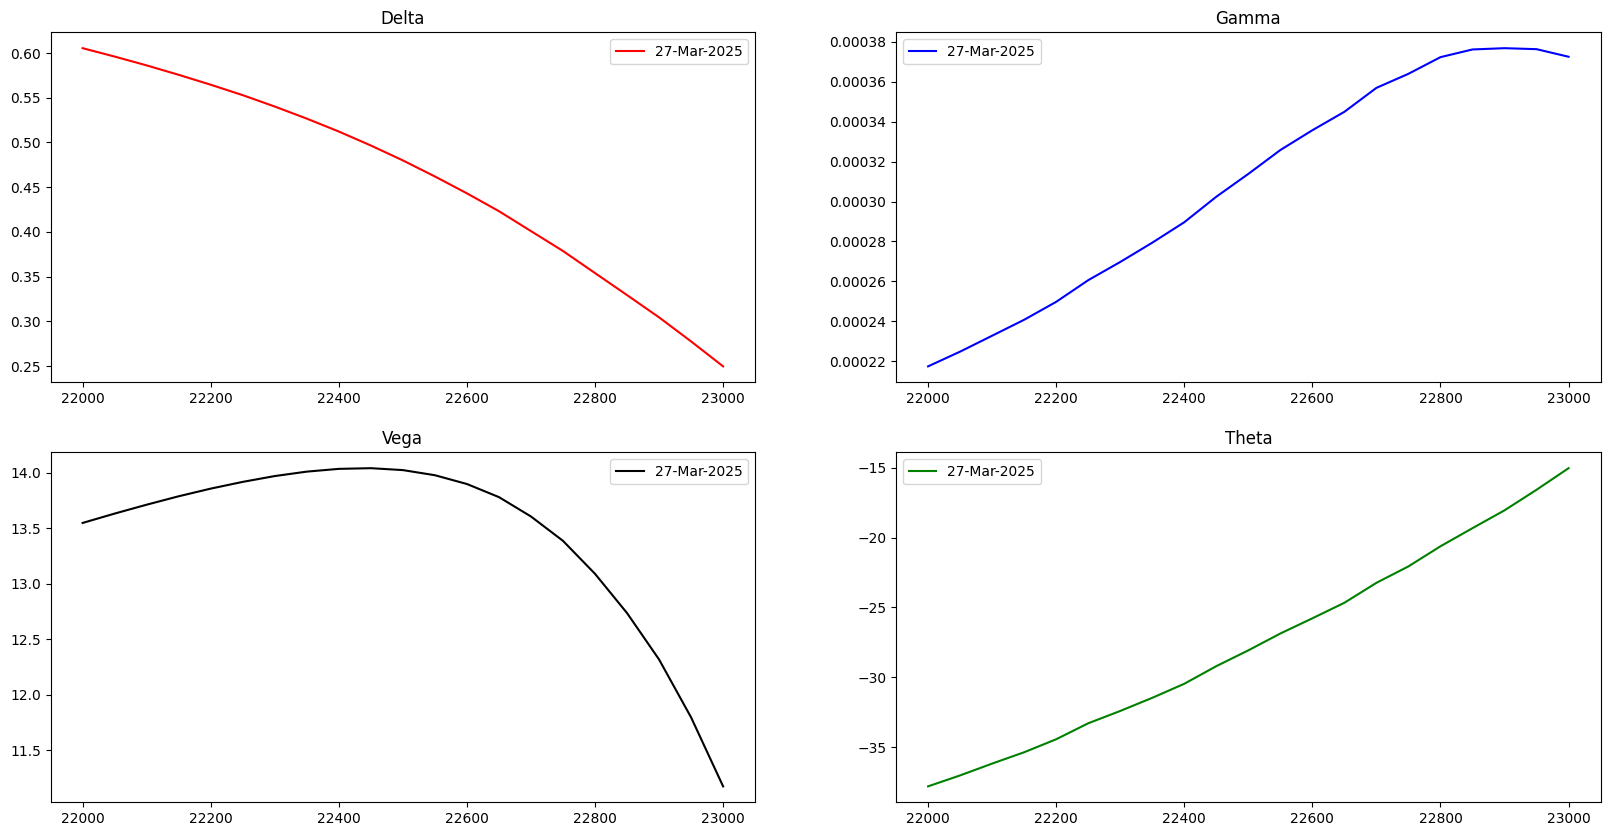

In [11]:
# Plot graph iteratively
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Greek parameters
greeks = {
    (0,0): ('Delta', 'r'),
    (0,1): ('Gamma', 'b'),
    (1,0): ('Vega', 'k'),
    (1,1): ('Theta', 'g')
}

# Plot all greeks in one loop
for (i,j), (greek, color) in greeks.items():
    axes[i,j].plot(df1['Strike'], df1[greek], color=color, label=expiration)
    axes[i,j].set_title(greek)
    axes[i,j].legend()

plt.show()